

---


  

> # **군AI교육지원사업**
**자연어 처리**



---

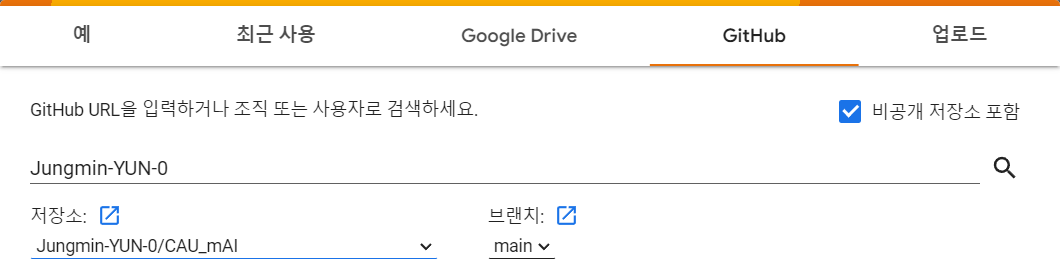

##WEEK 7
=========
### 1. Assignment Solution (week6) 

### 2. Attention
>2-1. vanilla seq2seq
>
>2-2. seq2seq with attention

## 1. Assignment Solution (week6)

**[before]** charcater-level RNN

appl → pple

**[Assigment]** word-level RNN

Repeat is the best medicine for → is the best medicine for memory

- Hint: one-hot vector 대신 embedding 사용


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
sentence = "Repeat is the best medicine for memory".split()

In [3]:
"""
자유롭게 코드 구현 (필요한 요소들 힌트)
- vocab
- word2index
- index2word
- 'Repeat is the best medicine for'과 'is the best medicine for memory'를 정수로 인코딩 필요
- 모델 구현(embedding 사용)
- ...
"""

"\n자유롭게 코드 구현 (필요한 요소들 힌트)\n- vocab\n- word2index\n- index2word\n- 'Repeat is the best medicine for'과 'is the best medicine for memory'를 정수로 인코딩 필요\n- 모델 구현(embedding 사용)\n- ...\n"

vocab

In [4]:
vocab = list(set(sentence))

In [5]:
print(vocab)

['is', 'the', 'for', 'Repeat', 'memory', 'medicine', 'best']


word2idx

In [6]:
word2index = {tkn: i for i, tkn in enumerate(vocab, 1)}     # 단어에 고유한 정수 부여
word2index['<unk>']=0

In [7]:
print(word2index)

{'is': 1, 'the': 2, 'for': 3, 'Repeat': 4, 'memory': 5, 'medicine': 6, 'best': 7, '<unk>': 0}


In [8]:
print(word2index['memory'])

5


idx2word

In [9]:
index2word = {v: k for k, v in word2index.items()}

In [10]:
print(index2word)

{1: 'is', 2: 'the', 3: 'for', 4: 'Repeat', 5: 'memory', 6: 'medicine', 7: 'best', 0: '<unk>'}


In [11]:
print(index2word[2])

the


build data

In [12]:
def build_data(sentence, word2index):
    encoded = [word2index[token] for token in sentence]    # word → index 
    input_seq, label_seq = encoded[:-1], encoded[1:]    # input sequence, label sequence
    input_seq = torch.LongTensor(input_seq).unsqueeze(0)    # 차원 하나 추가 (for batch)
    label_seq = torch.LongTensor(label_seq).unsqueeze(0)    # //
    return input_seq, label_seq

In [13]:
X, Y = build_data(sentence, word2index)

In [14]:
print('input sequence:', X)    # (Repeat is the best medicine for)
print('label sequence:', Y)    # (is the best medicine for memory)

input sequence: tensor([[4, 1, 2, 7, 6, 3]])
label sequence: tensor([[1, 2, 7, 6, 3, 5]])


model

In [15]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_first=True):
        super(Net, self).__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)     # for word embedding
        self.rnn_layer = nn.RNN(embedding_dim, hidden_dim, batch_first=batch_first)
        self.linear = nn.Linear(hidden_dim, vocab_size) # output size -> one-hot vector size (vocab size)

    def forward(self, x):    # (batch_size, sequence_length)
        # 1(Embedding Layer)
        output = self.embedding_layer(x)    # →(batch_size, sequence_length, embedding_dim)
        # 2(RNN Layer)
        output, hidden = self.rnn_layer(output)     # → output(batch_size, sequence_length, hidden_dim), hidden (1, batch_size, hidden_dim)
        # 3(최종 출력 Layer)
        output = self.linear(output)    # →(batch_size, sequence_length, vocab_size)
        return output.view(-1, output.size(2))  # batch 차원 제거 (batch_size*sequence_length, vocab_size)

In [16]:
# hyperparameter
vocab_size = len(word2index)  # <unk> 토큰 포함
embedding_dim = 5
hidden_dim = 16

In [17]:
model = Net(vocab_size, embedding_dim, hidden_dim, batch_first=True)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters())

In [18]:
# 임의의 예측(random initialized weight)
output = model(X)
print(output)

tensor([[-0.1299, -0.1773,  0.3440, -0.0532,  0.0311,  0.2926,  0.6401, -0.0310],
        [-0.0641,  0.0242,  0.0254,  0.1657, -0.2457,  0.2828, -0.0220, -0.0163],
        [ 0.0674, -0.3636,  0.3366, -0.0815, -0.2646,  0.4598,  0.2588,  0.3346],
        [-0.0952, -0.1635,  0.2257,  0.0527, -0.2977,  0.2368,  0.3597, -0.1342],
        [-0.3128,  0.0028,  0.0819, -0.0597,  0.1461,  0.2948,  0.7705, -0.0951],
        [-0.2279,  0.0050,  0.2847,  0.0610,  0.0014,  0.1713,  0.5257,  0.0125]],
       grad_fn=<ViewBackward0>)


In [19]:
print(output.shape)

torch.Size([6, 8])


train

In [20]:
for step in range(60):
    # gradient initialization
    optimizer.zero_grad()
    # forward
    output = model(X)
    # compute loss
    loss = loss_function(output, Y.view(-1))
    # backward
    loss.backward()
    # parameter update
    optimizer.step()
    if step % 5 == 0:
        print("[{:02d}/60] {:.4f} ".format(step+1, loss))
        pred = output.argmax(-1).tolist()
        print(" ".join(["Repeat"] + [index2word.get(x) for x in pred]))
        print()

[01/60] 2.0774 
Repeat medicine memory memory medicine medicine medicine

[06/60] 2.0275 
Repeat medicine memory memory medicine medicine medicine

[11/60] 1.9789 
Repeat medicine memory best medicine medicine medicine

[16/60] 1.9312 
Repeat medicine memory best medicine medicine medicine

[21/60] 1.8838 
Repeat medicine memory best medicine medicine medicine

[26/60] 1.8361 
Repeat medicine the best medicine medicine medicine

[31/60] 1.7876 
Repeat medicine the best medicine medicine medicine

[36/60] 1.7378 
Repeat medicine the best medicine medicine memory

[41/60] 1.6864 
Repeat medicine the best medicine medicine memory

[46/60] 1.6330 
Repeat medicine the best medicine medicine memory

[51/60] 1.5774 
Repeat medicine the best medicine medicine memory

[56/60] 1.5193 
Repeat medicine the best medicine for memory



## 2. Attention

### 2-1. vanilla seq2seq

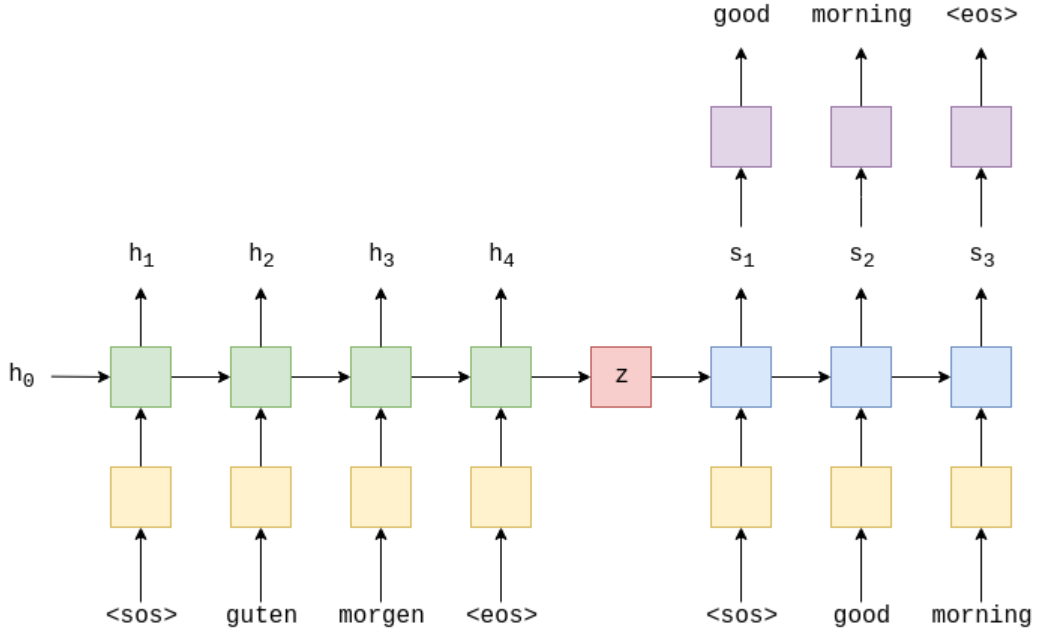

Sequence to Sequence Learning with Neural Networks

https://arxiv.org/abs/1409.3215

In [21]:
!pip install torchtext==0.10.0

     ---------------------------------------- 1.4/1.4 MB 7.7 MB/s eta 0:00:00
     -------------------------------------- 222.0/222.0 MB 6.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\cau\\anaconda3\\envs\\Project\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import spacy
import numpy as np

import random
import math
import time

In [ ]:
# for spacy tokenizer
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 19.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 542 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [ ]:
import de_core_news_sm
import en_core_web_sm

spacy_en = en_core_web_sm.load()
spacy_de = de_core_news_sm.load()

# tokenizer function 
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
    
# torchtext Field → data preprocesing
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
# Multi30k dataset
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC,TRG))

In [ ]:
print(f'Number of training examples: {len(train_data.examples)}')
print(f'Number of validation examples: {len(valid_data.examples)}')
print(f'Number of testing examples: {len(test_data.examples)}')

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [ ]:
SRC.build_vocab(train_data, min_freq=2)    # min_freq=2: 2번 이상 등장한 토큰에 대해서만 vocab에 추가. (2번 미만에 대해서는, <unk>로 대체)
TRG.build_vocab(train_data, min_freq=2)

In [ ]:
# Iterator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=batch_size, device=device)

**encoder**

- input sequence를 받아 고정된 크기의 context vector로 encode
  
  (input sequence의 모든 단어를 순차적으로 입력받아 마지막에 모든 단어 정보를 압축하여 context vector로 만들어줌)


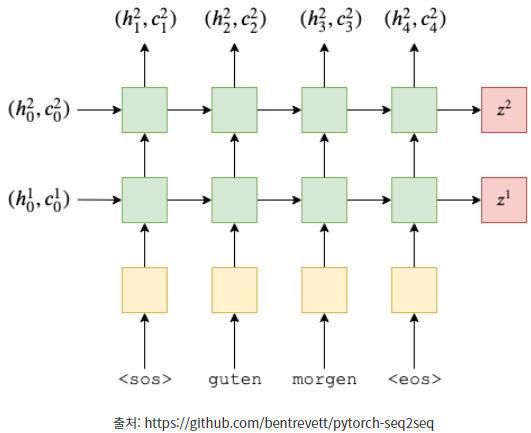

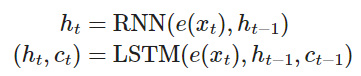

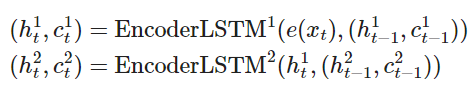

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # embedding: 입력값을 emd_dim 벡터로 변경
        self.embedding = nn.Embedding(input_dim, emb_dim)    # input_dim = input(source) vocab size

        # embedding을 입력받아 hid_dim 크기의 hidden state, cell 출력
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):    # [src_len, batch_size]
        embedded = self.embedding(src)    # [src len, batch size, emb dim]
        embedded = self.dropout(embedded)

        outputs, (hidden, cell) = self.rnn(embedded)    # initial hidden state는 zero tensor
        # output: [src_len, batch_size, hid dim * n directions]
        # hidden: [n layers * n directions, batch_size, hid dim]
        # cell: [n layers * n directions, batch_size, hid dim]

        return hidden, cell

**decoder**

- encode된 context vector를 받아 decode하여 target sequence를 생성
- 입력받은 context vector는 decoder의 첫번째 hidden state에 사용됨
- 초기 입력은 < sos>. 문장의 끝은 < eos>

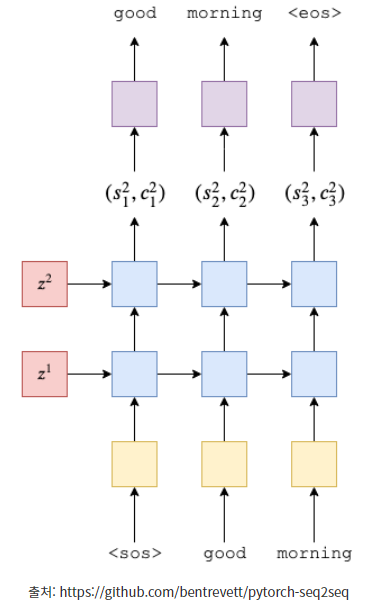

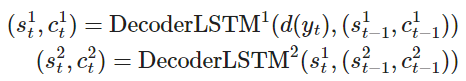

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # content vector를 입력받아 emb_dim 출력
        self.embedding = nn.Embedding(output_dim, emb_dim)

        # embedding을 입력받아 hid_dim 크기의 hidden state, cell 출력
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

        self.out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input: [batch_size]
        # hidden: [n layers * n directions, batch_size, hid dim]
        # cell: [n layers * n directions, batch_size, hid dim]

        input = input.unsqueeze(0) # input: [1, batch_size], 첫번째 input은 <SOS>
        embedded = self.embedding(input) # [1, batch_size, emd dim]
        embedded = self.dropout(embedded)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        # seq len and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]
        # seq_len=1: only decode one token at a time
        prediction = self.out(output.squeeze(0)) # [batch size, output dim]

        return prediction, hidden, cell

**seq2seq**

- encoder와 decoder를 조합
- receiving the input/source sentence
- using the encoder to produce the context vectors
- using the decoder to produce the predicted output/target sentence

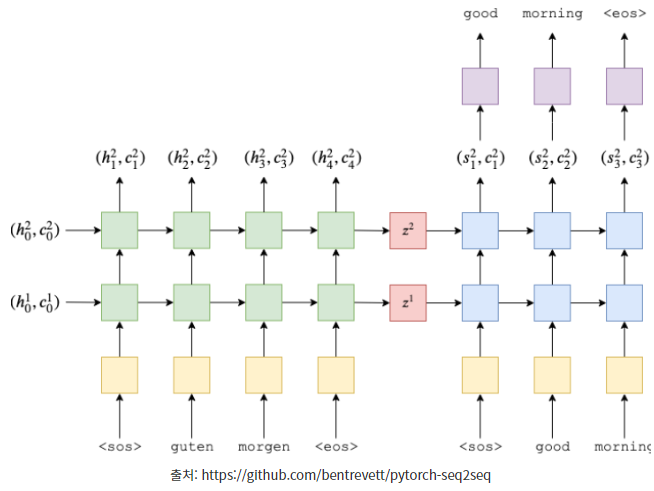

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [src len, batch size]
        # trg: [trg len, batch size]
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0] # 타겟 토큰 길이
        trg_vocab_size = self.decoder.output_dim # context vector의 차원

        # decoder의 output을 저장하기 위한 tensor
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # initial hidden state
        hidden, cell = self.encoder(src)

        # 첫 번째 입력값 <sos> 토큰
        input = trg[0,:]

        for t in range(1,trg_len): # <eos> 제외하고 trg_len-1 만큼 반복
            output, hidden, cell = self.decoder(input, hidden, cell)

            # prediction 저장
            outputs[t] = output

            # teacher forcing을 사용할지, 말지 결정
            teacher_force = random.random() < teacher_forcing_ratio

            # 가장 높은 확률을 갖은 값 얻기
            top1 = output.argmax(1)

            # teacher forcing의 경우에 다음 lstm에 target token 입력
            input = trg[t] if teacher_force else top1

        return outputs

**teacher forcing**

- 일정 확률로 다음 LSTM cell에 prediction이 아닌, target token을 입력
- 학습 초기에 안정적으로 학습할 수 있도록 기여.

  (학습 초기에는 틀린 단어를 예측할 확률이 높음. 그래서 이때 틀린 단어를 다음 LSTM cell에 입력하기보다는, 이를 교정하여 target 단어를 다음 LSTM cell로 넘겨줌)


In [ ]:
# hyperparameter

input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
enc_emb_dim = 256 
dec_emb_dim = 256
hid_dim = 512
n_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

In [ ]:
# 모델 생성
enc = Encoder(input_dim, enc_emb_dim, hid_dim, n_layers, enc_dropout)
dec = Decoder(output_dim, dec_emb_dim, hid_dim, n_layers, dec_dropout)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
# weight initialization
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
# parameter 수
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainableparameters')

The model has 13,898,501 trainableparameters


In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters())

trg_pad_idx = TRG.vocab.stoi[TRG.pad_token]    # padding에 해당하는 인덱스 무시

# loss function
criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

**Train**

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()

        output = model(src,trg)    # [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)    # loss 계산을 위해 1d로 변경
        trg = trg[1:].view(-1)    # loss 계산을 위해 1d로 변경

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

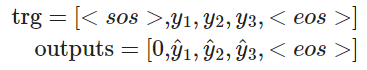

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # output: [trg len, batch size, output dim]
            output = model(src, trg, 0)    # teacher forcing off
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)    # [(trg len -1) * batch size, output dim]
            trg = trg[1:].view(-1)    # [(trg len -1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
# function to count training time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# 학습 시작
num_epochs = 10
clip = 1

best_valid_loss = float('inf')

for epoch in range(num_epochs):
   
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 37s
	Train Loss: 5.044
	 Val. Loss: 4.847
Epoch: 02 | Time: 0m 37s
	Train Loss: 4.451
	 Val. Loss: 4.646
Epoch: 03 | Time: 0m 37s
	Train Loss: 4.156
	 Val. Loss: 4.617
Epoch: 04 | Time: 0m 37s
	Train Loss: 4.006
	 Val. Loss: 4.468
Epoch: 05 | Time: 0m 38s
	Train Loss: 3.896
	 Val. Loss: 4.441
Epoch: 06 | Time: 0m 37s
	Train Loss: 3.772
	 Val. Loss: 4.455
Epoch: 07 | Time: 0m 38s
	Train Loss: 3.634
	 Val. Loss: 4.423
Epoch: 08 | Time: 0m 37s
	Train Loss: 3.528
	 Val. Loss: 4.245
Epoch: 09 | Time: 0m 37s
	Train Loss: 3.431
	 Val. Loss: 4.213
Epoch: 10 | Time: 0m 37s
	Train Loss: 3.306
	 Val. Loss: 4.096


In [ ]:
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 4.083


### 2-2. seq2seq with attention

**Attention**

- query가 주어졌을 때, key값을 통해 value값에 접근하는 것
- query와 비슷한 key값을 찾아서, 비슷한 정도에 따라 weight를 정하고, 각 key의 value값을 weight값 만큼 가져와서 모두 더하는 것

In [ ]:
 dic = {'computer': 9, 'dog': 2, 'cat': 3}
 
 # →쿼리가 주어졌을 때 key 값에 따라 value 값에 접근 가능

In [ ]:
def how_similar(key, query):
  word_pair = sorted([key, query])
  if word_pair == ['computer', 'dog']:
    sim = 0.2
  elif word_pair == ['cat', 'computer']:
    sim = 0.2
  elif word_pair == ['cat', 'dog']:
    sim = 0.4
  elif word_pair == ['computer', 'computer']:
    sim = 1
  elif word_pair == ['cat', 'cat']:
    sim = 1
  elif word_pair == ['dog', 'dog']:
    sim = 1
  return sim

In [ ]:
import numpy as np
def softmax(a):
  exp_a = np.exp(a)
  sum_exp_a = np.sum(exp_a)
  return exp_a / sum_exp_a

In [ ]:
def key_value_func(query):
    weights = []

    for key in dic.keys():    # dict_keys(['computer', 'dog', 'cat'])
        # similarity 값을 채워 넣는다.
        weights += [how_similar(key, query)]

    # 모든 weight들을 구한 후에 softmax를 계산한다.
    weights = softmax(weights)
    answer = 0

    for weight, value in zip(weights, dic.values()):
        answer += weight * value

    return answer

In [ ]:
query = 'dog'
answer = key_value_func(query)
print(answer)

3.848775999308571


- 입력 문장에서 예측해야할 단어와 연관있는 단어에 집중(attention)해서 보는 것

- vanilla seq2seq의 경우, 디코더에서 마지막 hidden state만 사용하다보니, 하나의 고정된 크기의 벡터에 모든 정보를 압축하게 되고, 이로 인해 정보 손실이 발생. 이러한 문제를 해결하기 위하여, 마지막 hidden state뿐만 아니라, 각 time-step의 hidden state도 활용하기 위한 개념

- Attention mechanism : Decoder에서 출력 단어를 예측하는 매 시점(step)마다, Encoder의 sequence를 다시 참고. 이 때, 입력 시퀀스를 동일한 비중으로 참고하는 것이 아닌, 예측 단어와 관련이 있는 입력 단어를 더욱 치중해서 보기 때문에 Attention이란 단어를 사용

- key, value: 인코더의 각 time-step별 output (source)
- query: 현재 time-step의 decoder output (target)
- vanilla seq2seq: 모든 input을 받아 context vector를 반환
- seq2seq with attention: 디코더의 출력을 query로 하여, attention의 가중치를 구한 값을 context vector로 반환

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 실행후 런타임 다시시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,593 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

Data

In [3]:
df = pd.DataFrame([["i love you", "ich liebe dich"],
                    ["i love myself", "ich liebe mich"],
                    ["i like you", "ich mag dich"],
                    ["he love you", "er liebt dich"]], columns=['src', 'tar'])
df

,src,tar
0,i love you,ich liebe dich
1,i love myself,ich liebe mich
2,i like you,ich mag dich
3,he love you,er liebt dich


In [4]:
SOS_token = 0
EOS_token = 1

class Tokenizer:
    def __init__(self):
        self.vocab2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2vocab = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.n_vocab = len(self.vocab2index)

    def add_vocab(self, sentence):
        for word in sentence.split(" "):
            if word not in self.vocab2index:
                self.vocab2index[word] = self.n_vocab
                self.index2vocab[self.n_vocab] = word
                self.n_vocab += 1
    
    def to_seq(self, sentence):
        l = []
        for s in sentence.split(" "):
            l.append(self.vocab2index[s])
        return l

In [5]:
src_tok = Tokenizer()
for s in df['src'].values:
    for v in s.split(' '):
        src_tok.add_vocab(v)

tar_tok = Tokenizer()
for s in df['tar'].values:
    for v in s.split(' '):
        tar_tok.add_vocab(v)

print(src_tok.vocab2index)
print(tar_tok.vocab2index)

{'<SOS>': 0, '<EOS>': 1, 'i': 2, 'love': 3, 'you': 4, 'myself': 5, 'like': 6, 'he': 7}
{'<SOS>': 0, '<EOS>': 1, 'ich': 2, 'liebe': 3, 'dich': 4, 'mich': 5, 'mag': 6, 'er': 7, 'liebt': 8}


In [6]:
src_data = [src_tok.to_seq(s) for s in df['src'].values]
tar_data = [[SOS_token] + tar_tok.to_seq(s) + [EOS_token] for s in df['tar'].values]
print(src_data)
print(tar_data)

[[2, 3, 4], [2, 3, 5], [2, 6, 4], [7, 3, 4]]
[[0, 2, 3, 4, 1], [0, 2, 3, 5, 1], [0, 2, 6, 4, 1], [0, 7, 8, 4, 1]]


**Encoder**

In [7]:
# hparam
hparam = {}
hparam['embed_size'] = 16

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.embed = nn.Embedding(src_tok.n_vocab, hparam['embed_size'])    # 8, 16
        self.rnn = nn.LSTM(input_size=hparam['embed_size'], hidden_size=hparam['embed_size'])    # 16, 16

    def forward(self, x, h, c):    # [1]
        x = self.embed(x)    # [embed_size]
        x = x.view((1, 1, -1))    # [1,1,embed_size]
        x, (h, c) = self.rnn(x, (h, c))
        # x: [1,1,embed_size]
        # h: [1,1,embed_size] (hidden state)
        # c: [1,1,embed_size] (cell state)
        return h, c

**Decoder**

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(tar_tok.n_vocab, hparam['embed_size']) # embed_size = 4
        self.rnn = nn.LSTM(input_size=hparam['embed_size'], hidden_size=hparam['embed_size'])

    def forward(self, x, h, c):    # [1]
        x = self.embed(x)    # [embed_size]
        x = x.view((1, 1, -1))    # [1,1,embed_size]
        x, (h, c) = self.rnn(x, (h, c))
        # x: [1,1,embed_size]
        # h: [1,1,embed_size] (hidden state)
        # c: [1,1,embed_size] (cell state)
        return h, c

**Attention**

In [10]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.wc = nn.Linear(hparam['embed_size'] * 2, hparam['embed_size']) # (embed_size * 2, embed_size) = (8, 4)
        self.tanh = nn.Tanh()
        self.wy = nn.Linear(hparam['embed_size'], tar_tok.n_vocab) # (embed_size, word_cnt)
    def forward(self, x):  # [1,1,embed_size * 2]
        x = self.wc(x)    # [1,1,embed_size]
        x = self.tanh(x)    # [1,1,embed_size]
        x = self.wy(x)    # [1,1,word_cnt]
        x = F.log_softmax(x, dim=2)    # [1,1,word_cnt]
        return x

In [30]:
encoder = Encoder()
decoder = Decoder()
attention = Attention()

enc_optimizer = optim.RMSprop(encoder.parameters(), lr=0.01)
dec_optimizer = optim.RMSprop(decoder.parameters(), lr=0.01)
att_optimizer = optim.RMSprop(attention.parameters(), lr=0.01)
criterion = nn.NLLLoss()

loss_hist = []
for epoch in range(40):
    loss_avg = []

    for batch in range(len(src_data)):

        loss = 0

        src_train = torch.LongTensor(src_data[batch])

        h, c = torch.zeros((1, 1, hparam['embed_size'])), torch.zeros((1, 1, hparam['embed_size']))
        # h: [1,1,embed_size]
        # c: [1,1,embed_size]

        enc_out = torch.Tensor([])
        
        for i in range(len(src_train)):    
            # x: [1]
            h, c = encoder(src_train[i], h, c)
            # h: [1,1,embed_size]
            # c: [1,1,embed_size]
            enc_out = torch.cat((enc_out, h))        # [src_len, 1, embed_size]

        tar_train = torch.LongTensor(tar_data[batch])

        sent = []

        # teacher forcing rate
        rate = 0.5

        # teacher forcing
        if rate > np.random.rand():
            for i in range(len(tar_train[:-1])):
                h, c = decoder(tar_train[i], h, c)
                # h: [1,1,embed_size]
                # c: [1,1,embed_size]

                ## Attention Score (t 시점 state의 encoder h)
                ## Decoder에서는 다음 단어를 생성하기 위해 Encoder에 입력된 단어 중 어떤 단어에 집중해야할지 점수를 매김
                score = enc_out.matmul(h.view((1,hparam['embed_size'],1)))
                # [src_len, 1, 1]

                ## Attention Distrobiton
                ## Attention Score에 softmax를 적용하여, 각 입력에 대하여 얼마나 집중할지에 대하여 비율 값으로 표현함
                att_dis = F.softmax(score, dim=0)
                # [src_len,1,1]

                ## Attention Value
                ## Encoder의 LSTM에서 각 단어의 출력을 Attention Distribution을 가중치로 하여 곱하고, 곱해진 값을 더하여 하나의 벡터로 합침
                # sum((src_len,1,embed_size) * (src_len,1,1))
                att_v = torch.sum(enc_out * att_dis, dim=0).view(1,1,hparam['embed_size'])
                # [1,1,embed_size]

                ## Concatenation
                con = torch.cat((att_v, h), dim=2)

                out = attention(con)
                # [1,1,word_cnt]
                loss += criterion(out.view((1, -1)), tar_train[i+1].view(1))

                sent.append(tar_tok.index2vocab[out.argmax().detach().item()])

        # without teacher forcing
        else:
            dec_in = tar_train[0]
            
            for i in range(len(tar_train[:-1])):
                h, c = decoder(dec_in, h, c)
                score = enc_out.matmul(h.view((1,hparam['embed_size'],1)))
                att_dis = F.softmax(score, dim=0)
                att_v = torch.sum(enc_out * att_dis, dim=0).view(1,1,hparam['embed_size'])
                con = torch.cat((att_v, h), dim=2)
                out = attention(con)
                topv, topi = out.squeeze().topk(1)
                
                dec_in = topi[0].detach()
                
                loss += criterion(out.view((1, -1)), tar_train[i+1].view(1))
                
                sent.append(tar_tok.index2vocab[out.argmax().detach().item()])
                if dec_in == EOS_token:
                    break
        
        if (epoch + 1) % 20 == 0:
            print(epoch + 1, batch, loss.item())
            print(' '.join([tar_tok.index2vocab[t] for t in tar_train.detach().numpy()[1: ]]))
            print(' '.join(sent))
        
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        att_optimizer.zero_grad()

        loss = loss / len(df)
        loss.backward()

        enc_optimizer.step()
        dec_optimizer.step()
        att_optimizer.step()

        loss_avg.append(loss.item())

    loss_hist.append(sum(loss_avg))

    if (epoch + 1) % 20 == 0:
        print('avg loss', loss_hist[-1])
        print('=============================')

20 0 0.0928918793797493
ich liebe dich <EOS>
ich liebe dich <EOS>
20 1 0.09924932569265366
ich liebe mich <EOS>
ich liebe mich <EOS>
20 2 0.08688734471797943
ich mag dich <EOS>
ich mag dich <EOS>
20 3 0.12227397412061691
er liebt dich <EOS>
er liebt dich <EOS>
avg loss 0.10032563097774982
40 0 0.029108233749866486
ich liebe dich <EOS>
ich liebe dich <EOS>
40 1 0.03193923830986023
ich liebe mich <EOS>
ich liebe mich <EOS>
40 2 0.028778858482837677
ich mag dich <EOS>
ich mag dich <EOS>
40 3 0.039012908935546875
er liebt dich <EOS>
er liebt dich <EOS>
avg loss 0.03220980986952782


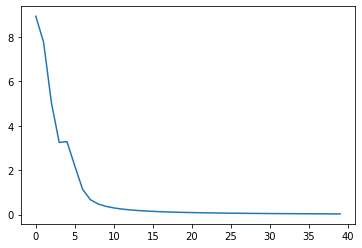

In [31]:
plt.plot(loss_hist)
plt.show()

In [33]:
def evaluation(batch):
    src_train = torch.LongTensor(src_data[batch])

    h, c = torch.zeros((1, 1, hparam['embed_size'])), torch.zeros((1, 1, hparam['embed_size']))
    # (1,1,embed_size) (1,1,embed_size)

    enc_out = torch.Tensor([])
    # (src_len, 1, embed_size)
    for i in range(len(src_train)):
        # x = (1)
        h, c = encoder(src_train[i], h, c)
        # (1,1,embed_size) (1,1,embed_size)
        enc_out = torch.cat((enc_out, h))

    tar_train = torch.LongTensor(tar_data[batch])

    sent = []
    att_met = []

    dec_in = tar_train[0]
    
    for i in range(len(tar_train[:-1])):
        h, c = decoder(dec_in, h, c)
        score = enc_out.matmul(h.view((1,hparam['embed_size'],1)))
        att_dis = F.softmax(score, dim=0)

        att_met.append(att_dis.detach().numpy().reshape((-1)).tolist()) # visualization

        att_v = torch.sum(enc_out * att_dis, dim=0).view(1,1,hparam['embed_size'])
        con = torch.cat((att_v, h), dim=2)
        out = attention(con)
        topv, topi = out.squeeze().topk(1)
        dec_in = topi[0].detach()
        
        sent.append(tar_tok.index2vocab[out.argmax().detach().item()])
        if dec_in == EOS_token: #
             break #
    
    s_arr = [src_tok.index2vocab[t] for t in src_train.detach().numpy()]
    t_arr = [tar_tok.index2vocab[t] for t in tar_train.detach().numpy()[1: ]]
    
    print(' '.join(s_arr))
    print(' '.join(t_arr))
    print(' '.join(sent))

    return att_met, s_arr, t_arr

In [34]:
def visualization(test_case):
    att_met, s_arr, t_arr = evaluation(test_case)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    c = ax.matshow(np.array(att_met).T, cmap='bone')

    ax.set_xticks(np.arange(len(t_arr)))
    ax.set_yticks(np.arange(len(s_arr)))

    ax.set_xticklabels(t_arr)
    ax.set_yticklabels(s_arr)

    fig.colorbar(c)
    plt.show()

i love you
ich liebe dich <EOS>
ich liebe dich <EOS>


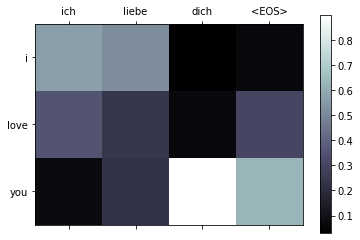

i love myself
ich liebe mich <EOS>
ich liebe mich <EOS>


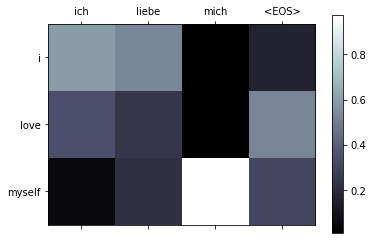

i like you
ich mag dich <EOS>
ich mag dich <EOS>


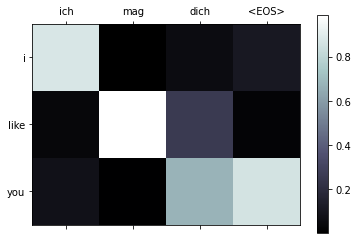

he love you
er liebt dich <EOS>
er liebt dich <EOS>


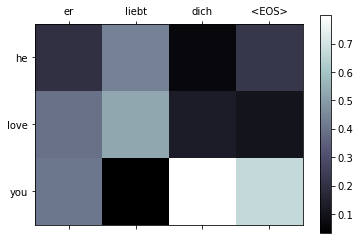

In [35]:
for i in range(4):
    visualization(i)

[reference]

https://github.com/bentrevett/pytorch-seq2seq

https://github.com/lunaB/Pytorch-Study


In [ ]:
|